## Setup

In [2]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import numpy as np
import pandas as pd
import random
import tensorflow as tf
import isuelogit as isl
import glob

In [3]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/Library/CloudStorage/OneDrive-Personal/data-science/github/gisuelogit


In [4]:
# Internal modules
from src.gisuelogit.visualizations import plot_predictive_performance, plot_convergence_estimates
from src.gisuelogit.etl import data_curation

## Read spatiotemporal data

In [5]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*fresno-link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[df['date'].dt.dayofweek.between(0, 3)]
# df = df[df['date'].dt.year == 2019]

df['period'] = df['date'].astype(str) + '-' + df['hour'].astype(str)
df['period'] = df.period.map(hash)

## Data curation

In [6]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

df = data_curation(df)

## Data processing

In [7]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year

In [13]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts,tt_ff,tt_avg,tf_inrix,speed_avg
count,2106.000000,36195.000000,31498.000000,36195.000000,36195.000000
mean,2190.535755,0.003414,0.003838,0.200588,17.469430
std,820.529432,0.004369,0.004567,0.230217,20.204228
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,1678.000000,0.000000,0.000000,0.000000,0.000000
50%,2101.000000,0.002503,0.002897,0.151000,15.068000
75%,2665.000000,0.004702,0.005621,0.289000,25.321000
max,4784.000000,0.070349,0.059900,4.605000,73.322000


In [12]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts,tt_ff,tt_avg,tf_inrix,speed_avg
count,1690.000000,28956.000000,25912.000000,28956.000000,28956.000000
mean,2161.492959,0.003377,0.003768,0.199493,18.895705
std,831.739616,0.004327,0.004473,0.229999,19.989374
min,31.000000,0.000000,0.000000,0.000000,0.000000
25%,1612.125000,0.000000,0.000000,0.000000,0.000000
50%,2100.250000,0.002491,0.002873,0.150000,19.573000
75%,2564.000000,0.004578,0.005427,0.279000,25.942000
max,4766.000000,0.070349,0.054574,3.775000,70.526000


In [27]:
print(1-1793.271103/1865.514775, 1-17.469430/18.895705)


0.03872586428590474 0.07548143877140334


In [10]:
# Select only dates used for previous paper
df = df.query('hour == 16')

## EDA

In [10]:
eda_df = df.copy()
eda_df['date'] = eda_df['date'].astype(str)

# Transform to monthly income
eda_df['median_inc'] = eda_df['median_inc']/12

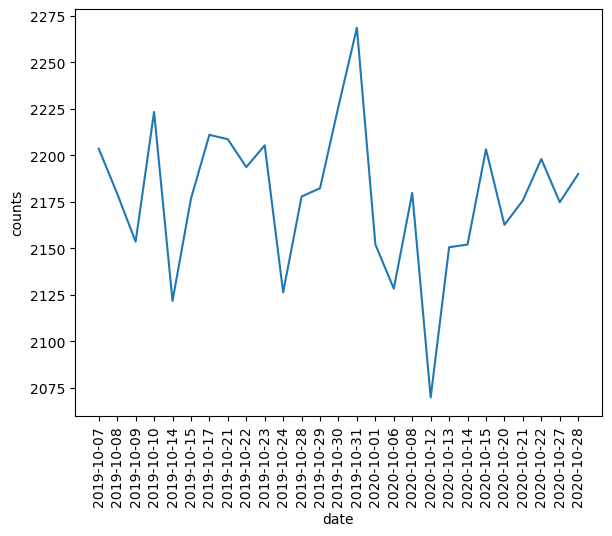

In [11]:
sns.lineplot(x= 'date', y = 'counts', data =eda_df.groupby('date')[['counts']].mean().reset_index())
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

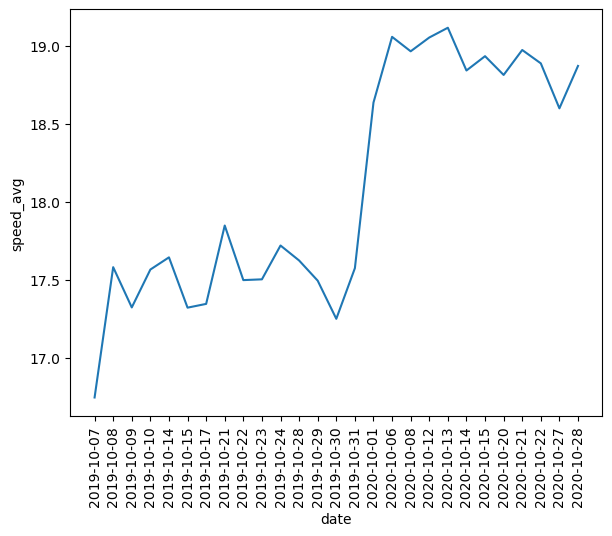

In [12]:
sns.lineplot(x= 'date', y = 'speed_avg', data =eda_df.groupby('date')[['speed_avg']].mean().reset_index())
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

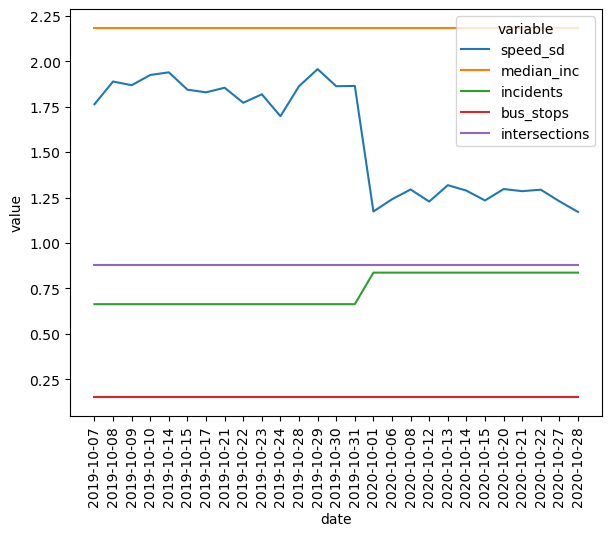

In [13]:
features_Z = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =pd.melt(eda_df.groupby('date')[features_Z].mean().reset_index(),id_vars= ['date']))
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

## Read models results

In [14]:
train_results_dfs = pd.read_csv('output/tables/221027112307_train_results_Fresno.csv', index_col = [0])
test_results_dfs = pd.read_csv('output/tables/221027112307_train_results_Fresno.csv', index_col = [0])

## Configuration

In [15]:
_XTICKS_SPACING = 50

### Model 1: Benchmark of gisuelogit and isuelogit


LUE: Benchmark of gisuelogit and isuelogit (utility only)
alpha =  0.15, beta  =  4.00


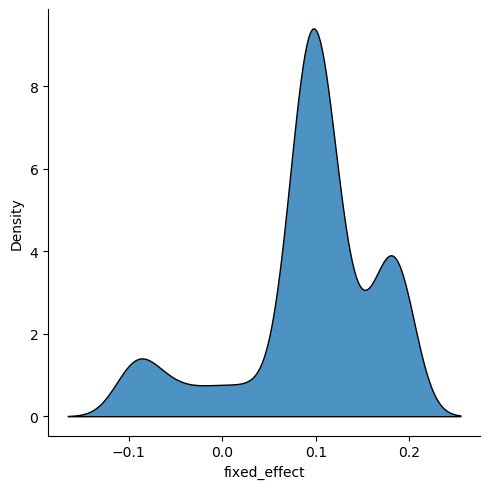

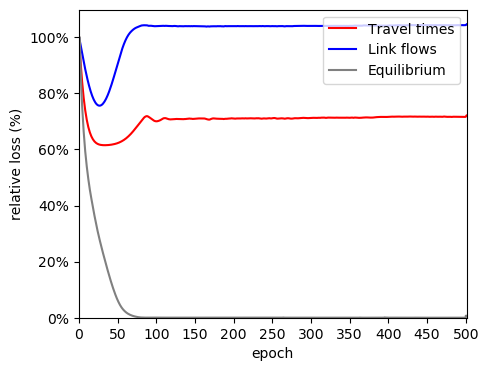

In [16]:
print('\nLUE: Benchmark of gisuelogit and isuelogit (utility only)')

sns.displot(pd.DataFrame({'fixed_effect':np.array(train_results_dfs[train_results_dfs.model == 'lue']['fixed_effect'])}),
        x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'lue'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'lue'],
                            xticks_spacing = _XTICKS_SPACING)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'lue']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'lue']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 2: OD + utility estimation with historic OD


ODLUE: OD + utility estimation with historic OD
alpha =  0.15, beta  =  4.00


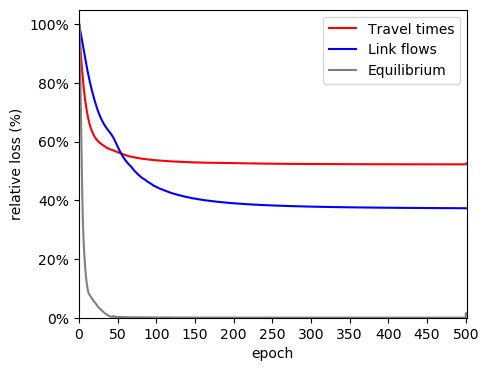

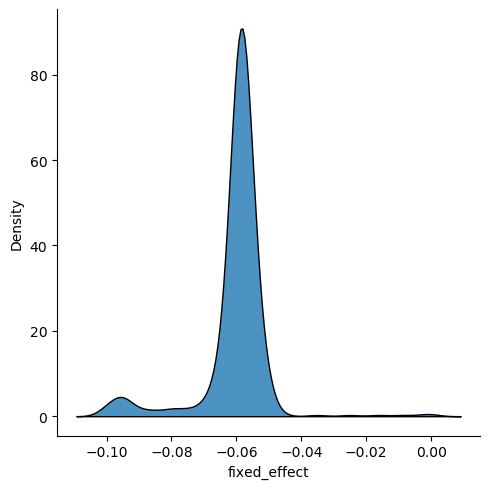

In [17]:
print('\nODLUE: OD + utility estimation with historic OD')

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'odlue'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'odlue'],
                            show_validation= False,
                            xticks_spacing = _XTICKS_SPACING)

sns.displot(pd.DataFrame({'fixed_effect':train_results_dfs[train_results_dfs.model == 'odlue']['fixed_effect']}),
        x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'odlue']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'odlue']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 3: ODLUE + link specific performance parameters (only alphas)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)
alpha =  1.05, beta  =  4.00


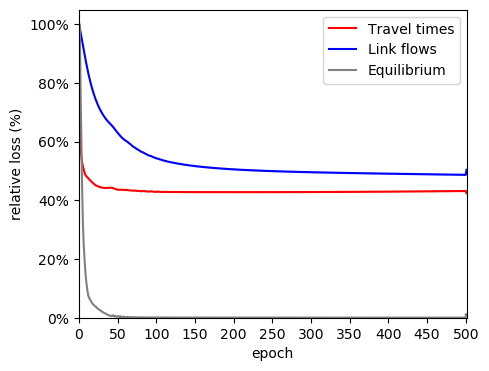

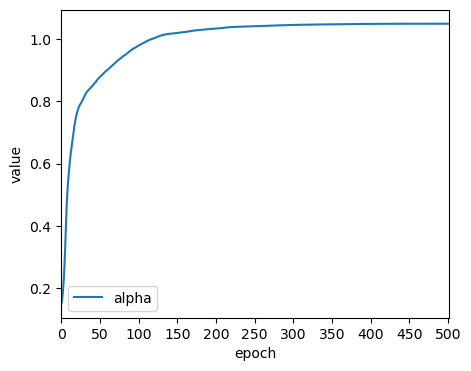

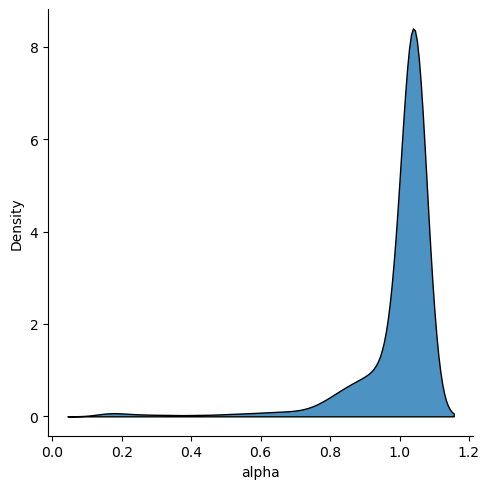

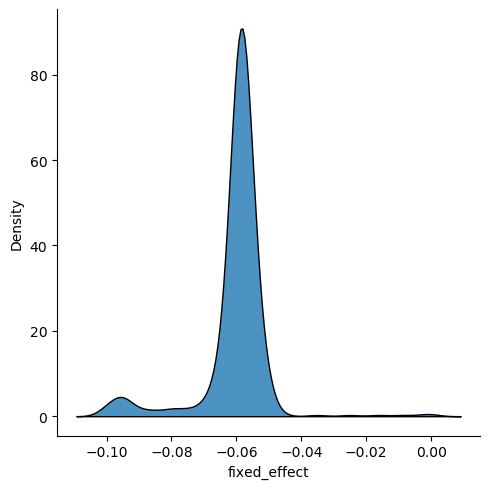

In [18]:
print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)')

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'odlulpe-1'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'odlulpe-1'],
                            show_validation= False,
                            xticks_spacing = _XTICKS_SPACING)

plot_convergence_estimates(estimates=train_results_dfs[train_results_dfs.model == 'odlulpe-1'][['epoch','alpha']],
                            xticks_spacing = _XTICKS_SPACING)

sns.displot(pd.DataFrame({'alpha':train_results_dfs[train_results_dfs.model == 'odlulpe-1']['alpha']}),
        x="alpha", multiple="stack", kind="kde", alpha = 0.8)

sns.displot(pd.DataFrame({'fixed_effect':np.array(train_results_dfs[train_results_dfs.model == 'odlue']['fixed_effect'])}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_1.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'odlulpe-1']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'odlulpe-1']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_1.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 5: ODLUE + link specific performance parameters (alphas and betas)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)
alpha =  0.80, beta  =  2.18


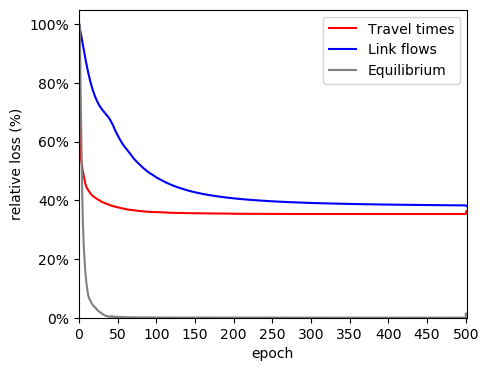

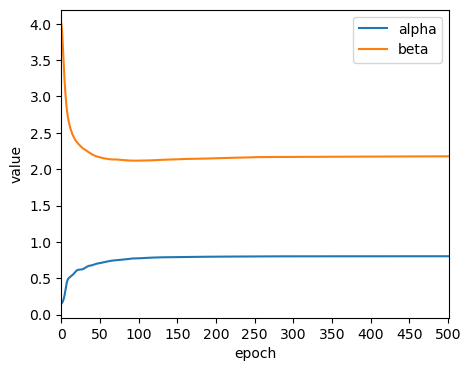

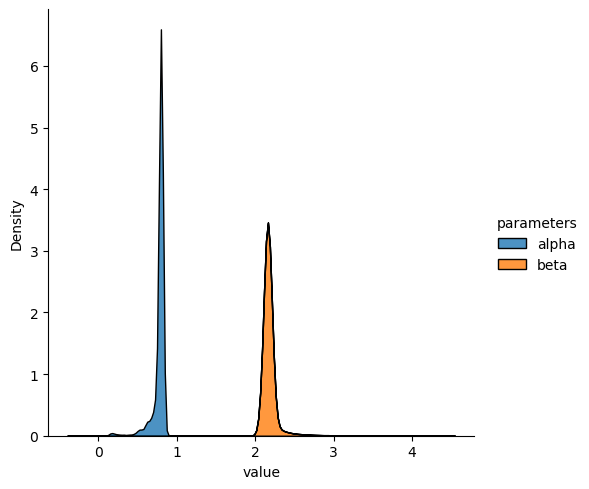

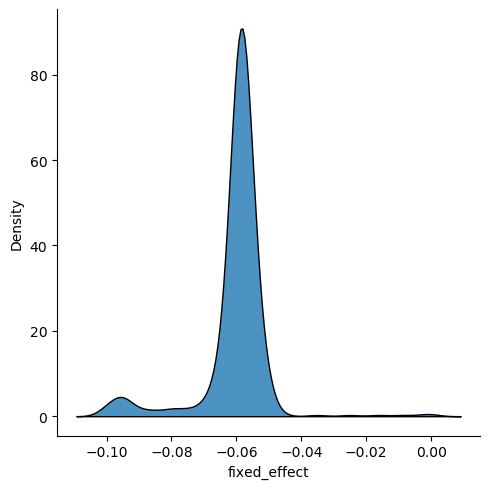

In [19]:
print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)')

train_results_dfs.loc[train_results_dfs.model == 'odlulpe_2','model'] = 'odlulpe-2'
test_results_dfs.loc[test_results_dfs.model == 'odlulpe_2','model'] = 'odlulpe-2'

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'odlulpe-2'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'odlulpe-2'],
                            show_validation= False,
                            xticks_spacing = _XTICKS_SPACING)

plot_convergence_estimates(
    estimates=train_results_dfs[train_results_dfs.model == 'odlulpe-2'][['epoch','alpha','beta']],
    xticks_spacing = _XTICKS_SPACING)

sns.displot(pd.melt(pd.DataFrame({'alpha':train_results_dfs[train_results_dfs.model == 'odlulpe-2']['alpha'],
                          'beta':train_results_dfs[train_results_dfs.model == 'odlulpe-2']['beta']}), var_name = 'parameters'),
            x="value", hue="parameters", multiple="stack", kind="kde", alpha = 0.8)

sns.displot(pd.DataFrame({'fixed_effect':train_results_dfs[train_results_dfs.model == 'odlue']['fixed_effect']}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_1.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'odlulpe-2']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'odlulpe-2']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_1.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

## Summary of parameters estimates

In [22]:
_EPOCHS = {'learning': 500, 'equilibrium': 50}

In [23]:
train_results_dfs = train_results_dfs[train_results_dfs['epoch'] <= _EPOCHS['learning']]

In [24]:
train_results_dfs

,model,loss_od,loss_flow,loss_tt,loss_total,loss_eq_flow,loss_eq_tt,epoch,tt,speed_sd,median_inc,incidents,bus_stops,intersections,alpha,beta,psc_factor,fixed_effect,relative_gap
0,lue,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.150000,4.000000,0.0,0.000000,0.000010
1,lue,1.000000,0.987322,0.954752,0.354191,1.000000,NaN,1,-0.498855,-0.499992,0.0,-0.499987,-0.499943,-0.499989,0.150000,4.000000,0.0,-0.001787,24.761214
2,lue,1.000000,0.972747,0.912675,0.345597,0.892439,NaN,2,-0.803327,-0.865334,0.0,-0.873386,-0.844833,-0.838423,0.150000,4.000000,0.0,-0.010335,0.670986
3,lue,1.000000,0.957802,0.874735,0.337689,0.815655,NaN,3,-1.025090,-1.158949,0.0,-1.173994,-1.115767,-1.100729,0.150000,4.000000,0.0,-0.018565,0.319642
4,lue,1.000000,0.942886,0.840815,0.330235,0.755353,NaN,4,-1.198690,-1.403418,0.0,-1.432467,-1.335838,-1.312928,0.150000,4.000000,0.0,-0.026819,0.201552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,odlulpe-2,1637.959652,0.382874,0.353676,0.002536,0.000297,NaN,497,-3.048074,-3.707728,0.0,-3.708657,-2.793998,-3.261020,0.802789,2.176415,0.0,-0.068977,0.006397
498,odlulpe-2,1647.713842,0.383095,0.353571,0.002509,0.000261,NaN,498,-3.044932,-3.707783,0.0,-3.709410,-2.793623,-3.258312,0.802780,2.176426,0.0,-0.068872,0.006682
499,odlulpe-2,1638.682139,0.382855,0.353667,0.002486,0.000295,NaN,499,-3.048906,-3.708705,0.0,-3.708921,-2.794773,-3.261642,0.802794,2.176462,0.0,-0.068962,0.006353
500,odlulpe-2,1648.328849,0.383075,0.353562,0.002460,0.000261,NaN,500,-3.045775,-3.708654,0.0,-3.709954,-2.793773,-3.258941,0.802785,2.176473,0.0,-0.068800,0.006675


In [25]:
models = train_results_dfs.model.unique()

In [ ]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model in models.keys():
    results = results.append(pd.DataFrame(
        {'parameter': ['tt'] + features_Z +
                      ['fixed_effect_mean','fixed_effect_std',
                       'alpha_mean', 'alpha_std',
                       'beta_mean', 'beta_std',
                       'od_mean', 'od_std',],
         'values': list(model.theta.numpy()) +
                   [np.mean(model.fixed_effect),np.std(model.fixed_effect),
                    np.mean(model.alpha),np.std(model.alpha),
                    np.mean(model.beta),np.std(model.beta),
                    np.mean(model.q),np.std(model.q)]}).\
                             assign(model = model.key)
                             )